In [11]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

etv_functions.enable_info_log_for_jupyter()

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid =  272650576

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
display(sr)
search_result = sr.download_all().stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 14,2019,SPOC,120,272650576,0.0,G022062
1,TESS Sector 15,2019,SPOC,120,272650576,0.0,G022062
2,TESS Sector 16,2019,SPOC,120,272650576,0.0,G022062
3,TESS Sector 20,2019,SPOC,120,272650576,0.0,G022062
4,TESS Sector 21,2020,SPOC,120,272650576,0.0,G022062
5,TESS Sector 22,2020,SPOC,120,272650576,0.0,G022062
6,TESS Sector 23,2020,SPOC,120,272650576,0.0,G022062
7,TESS Sector 26,2020,SPOC,120,272650576,0.0,G022062
8,TESS Sector 47,2021,SPOC,120,272650576,0.0,G04171


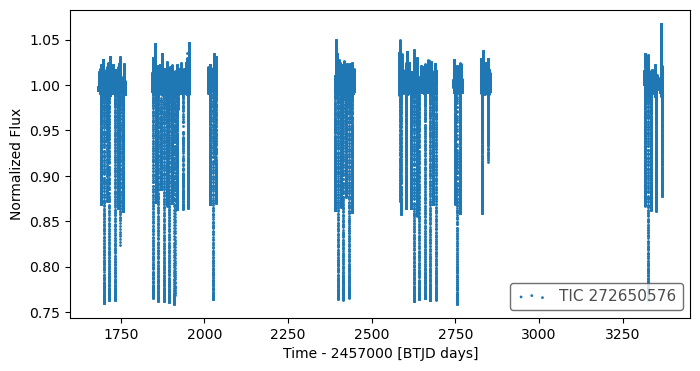

In [5]:
# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  # (time > 2893.16-1) & (time < 2893.16+1) 

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})


lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 2      
          default_view                         frequency      
                 label                     TIC 272650576      
             ls_method                          fastchi2      
frequency_at_max_power                             0.123 1 / d
             max_power                            0.0101      
               nyquist                          360.0008 1 / d
   period_at_max_power                             8.128     d
             frequency                  array (3031442,) 1 / d
                period                  array (3031442,)     d
                 power                  array (3031442,)      
                  meta <class 'collections.OrderedDict'>      
              targetid                <class 'NoneType'>      
8.1280451760443 d


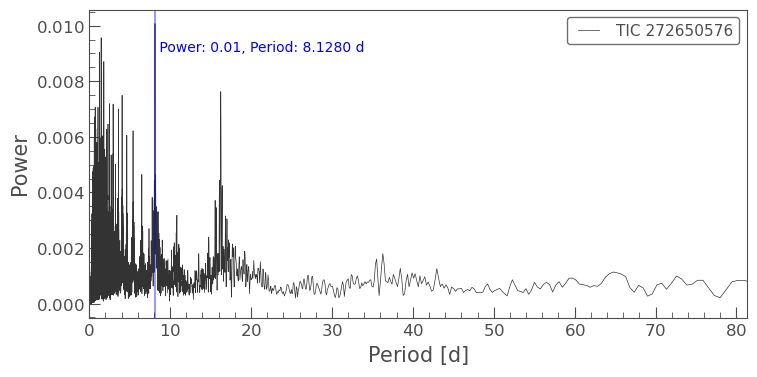

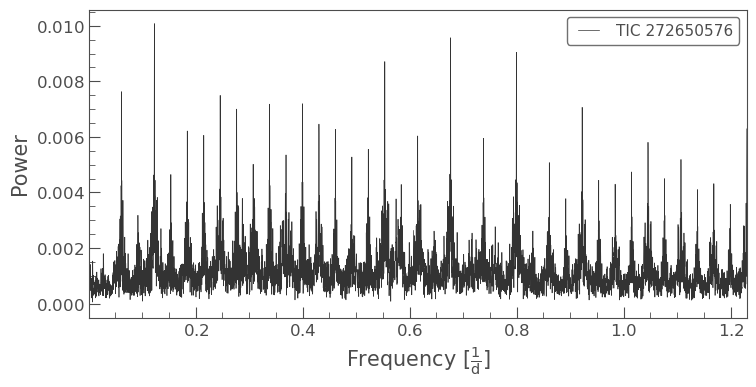

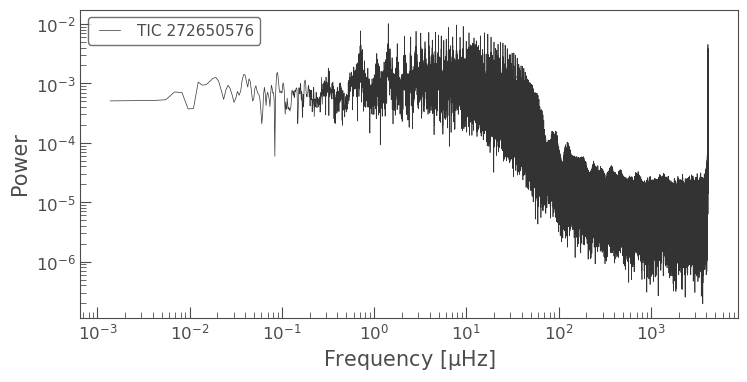

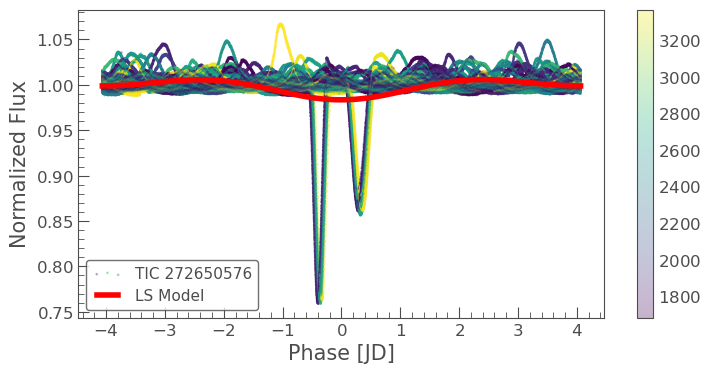

In [12]:
do_ls = True

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
          default_view                         frequency      
                 label                     TIC 272650576      
             ls_method                              fast      
frequency_at_max_power                            0.5747 1 / d
             max_power                            0.0036      
               nyquist                          360.0008 1 / d
   period_at_max_power                            1.7402     d
             frequency                  array (3031442,) 1 / d
                period                  array (3031442,)     d
                 power                  array (3031442,)      
                  meta <class 'collections.OrderedDict'>      
              targetid                <class 'NoneType'>      
1.7401642493039666 d

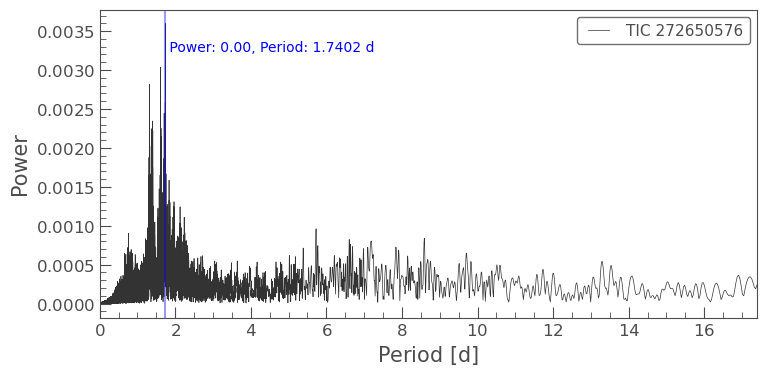

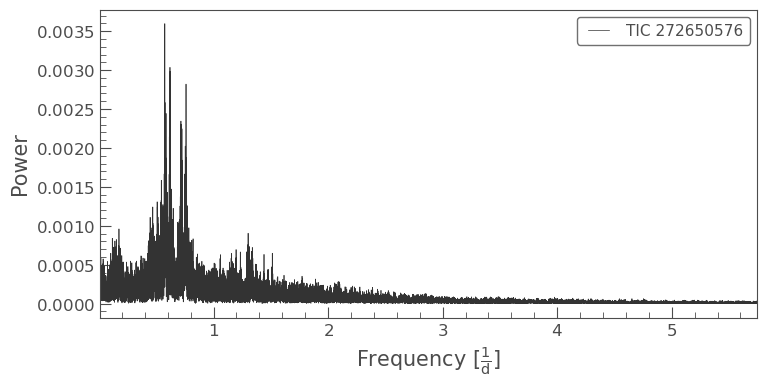

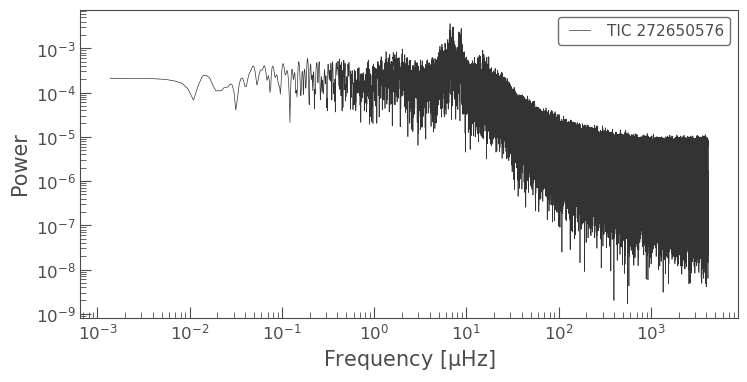

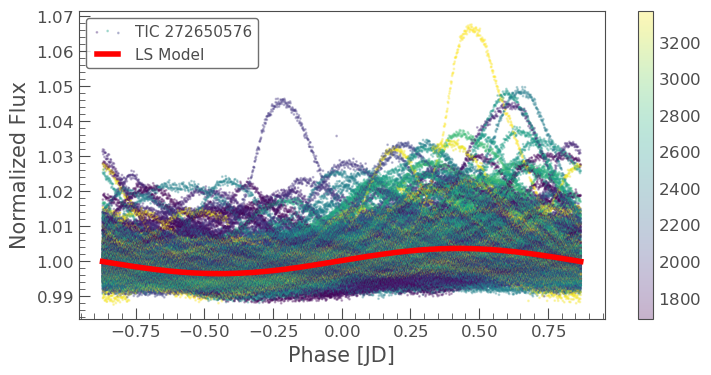

In [14]:
# second periodogram without the eclipses
do_ls = True

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"

    # mask out eclipses
    period = 16.256853  # MCMC fit on df_primary: 16.256853268128694 
    t0_primary = 1699.2054
    t0_secondary = 1691.7634
    duration_hr_primary = 6.9
    duration_hr_secondary = 9.9
    tmask = lc.create_transit_mask(transit_time=[t0_primary, t0_secondary], period=[period, period], duration=[1.2 * duration_hr_primary / 24, 1.2 * duration_hr_secondary / 24])
    lc = lc[~tmask]


    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


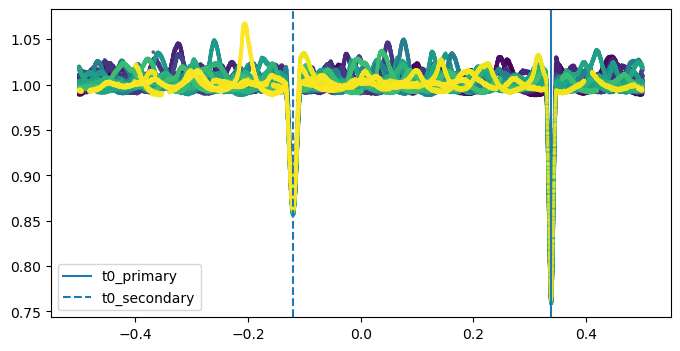

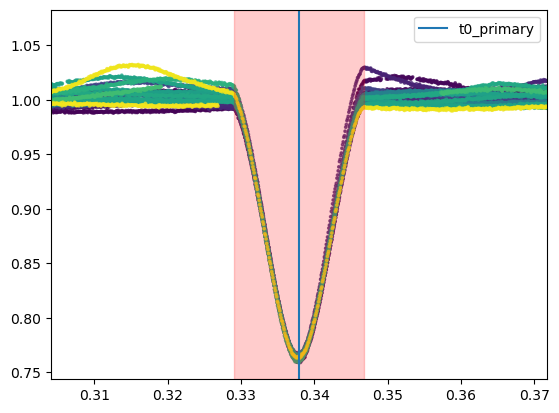

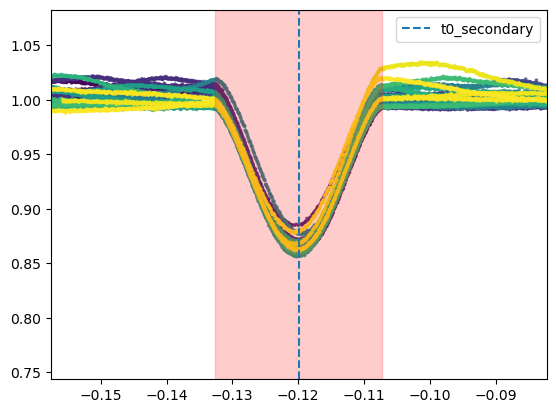

In [8]:
# define the orbital period and the t0 


# epoch=1699.2054, duration_hr=6.8891, period=16.256833, label="s0014-s0060:TCE1",
# epoch=1691.7634, duration_hr=9.8889, period=16.256819, label="s0014-s0060:TCE2",

period = 16.256833  # TCE1
period = 16.256853  # MCMC fit on df_primary: 16.256853268128694

t0_primary = 1699.2054
t0_secondary = 1691.7634

duration_hr_primary = 6.9
duration_hr_secondary = 9.9


# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = 3  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5), nearing the edge seems to break some of the subsequent codes 

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

### Now that the data is ready we can start 

In [16]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.7 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.7 * duration_hr_secondary / 24 / period
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1, -0.24, midpoint_p, 0.004, 1.0]
start_vals_s = [1.0, -0.135, midpoint_s, 0.006, 1.07]


# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1699.2054 0.3378690820419037
window_width_p (phase): 0.012379394708188603
Secondary: 1691.7634 -0.11990709394984622
window_width_s (phase): 0.017761740233487994


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1, -0.24, t0_primary, 0.004, 1.0, 16.256853],


emcee parallel enabled, use 11 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [03:10<00:00,  5.24it/s]


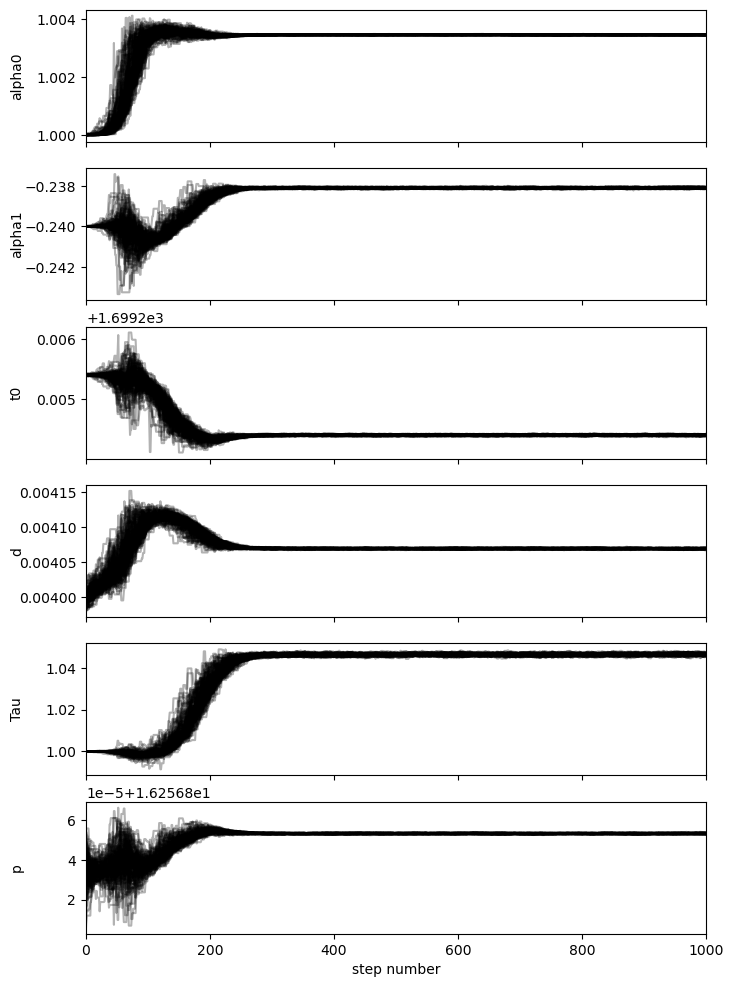

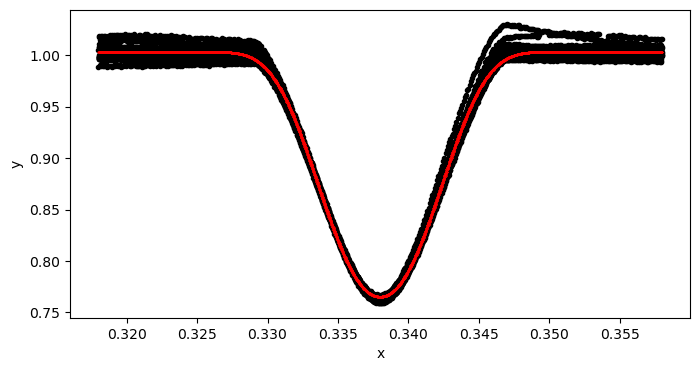

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, mean_p = 1.0034506961313099, -0.23810329901751986, 1699.2043940128028, 0.004069450805890426, 1.0464238415557103, 16.256853268128694
std_p: 2.0895676473398213e-07


In [15]:
# use MCMC to refine the period

use_mcmc_to_fit_period = False


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp
    # reload(etvp)
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0034506961313099, -0.23810329901751986, 1699.2043940128028, 0.004069450805890426, 1.0464238415557103, 16.256853268128694
    # std_p: 2.0895676473398213e-07
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1, -0.24, t0_primary, 0.004, 1.0, period],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-1,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.12it/s]


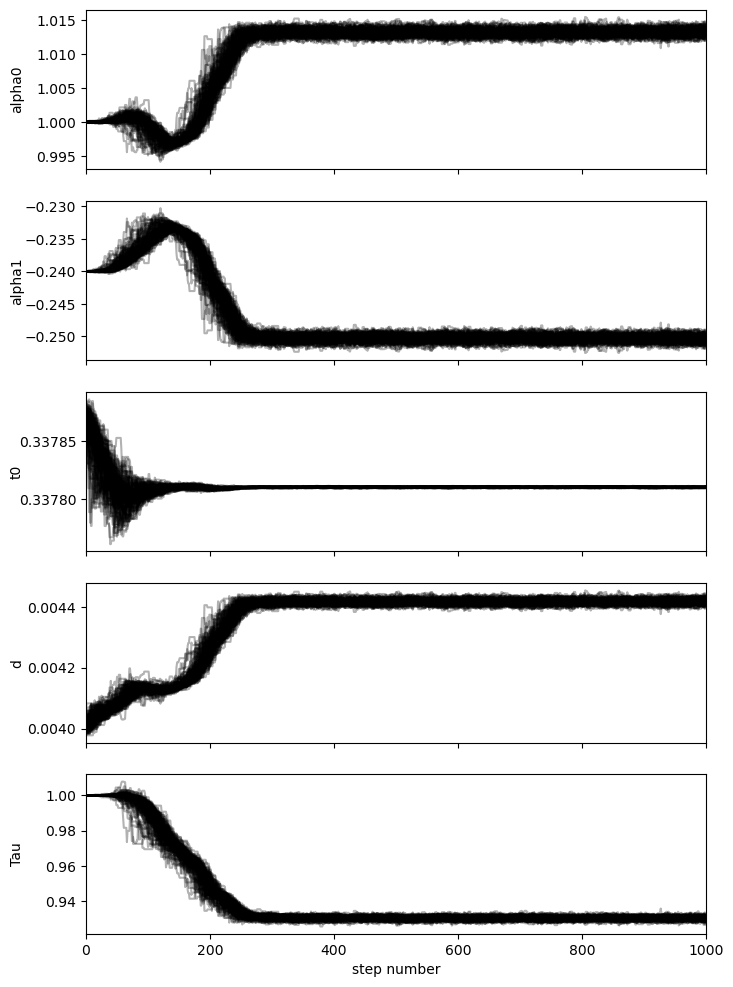

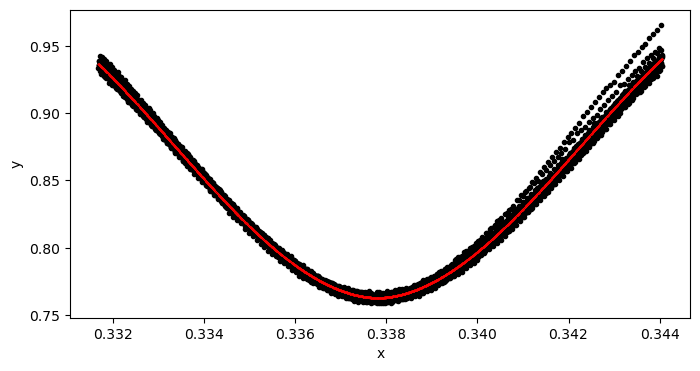

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.46it/s]


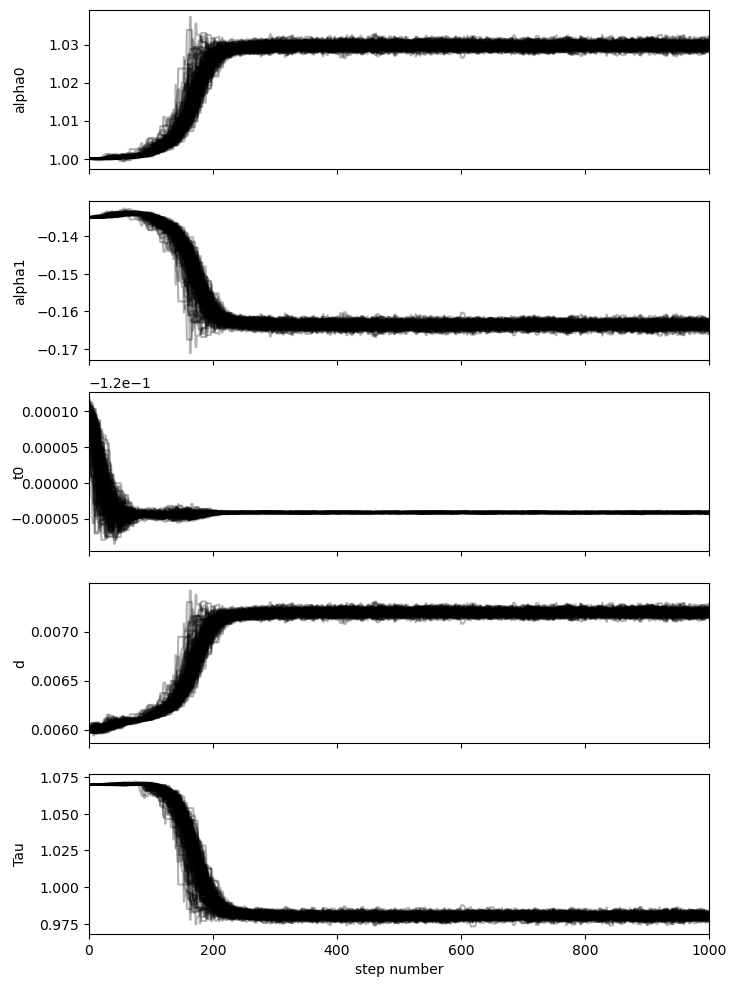

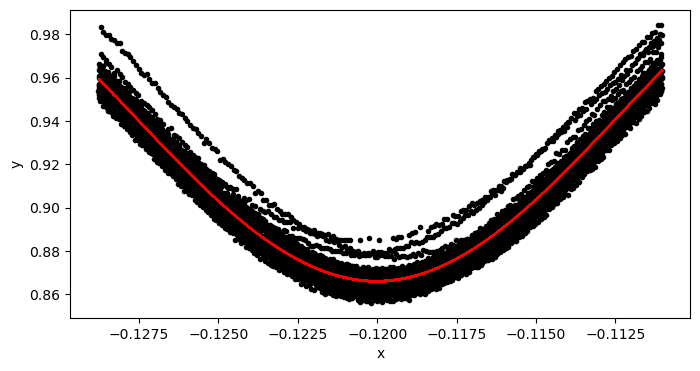

In [17]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
# Initial model params, based on MCMC period (with ingerss/egress)
# mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0034439231534114, -0.23809590137500114, 0.33780774253804846, 0.0040692258847070065, 1.0465030588708875
# mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0022908037652092, -0.13443899934688142, -0.11998450484782985, 0.005844973277963229, 1.2068833134048695
#
# Initial model params, based on MCMC period (no ingerss/egress)
# mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0131438511860815, -0.2502983827192327, 0.3378100490671454, 0.0044167570155645335, 0.9303764743321455
# mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0296357359316894, -0.16348427376787952, -0.12004152621387412, 0.007193435970025461, 0.9804692339578048


In [18]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0131438511860815, -0.2502983827192327, 0.3378100490671454, 0.0044167570155645335, 0.9303764743321455
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0296357359316894, -0.16348427376787952, -0.12004152621387412, 0.007193435970025461, 0.9804692339578048


100

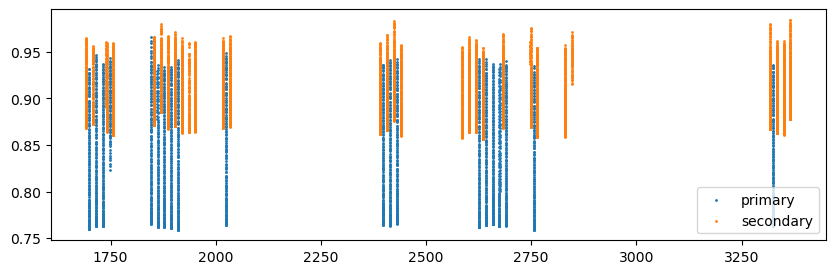

In [19]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1699.2054 16.256853 1699.2054


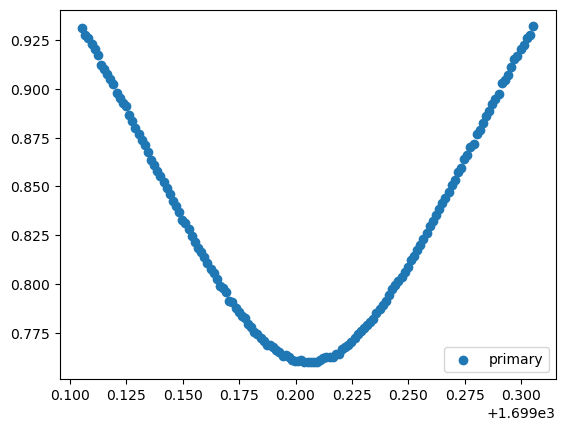

1699.2054 16.256853 1715.4622530000001


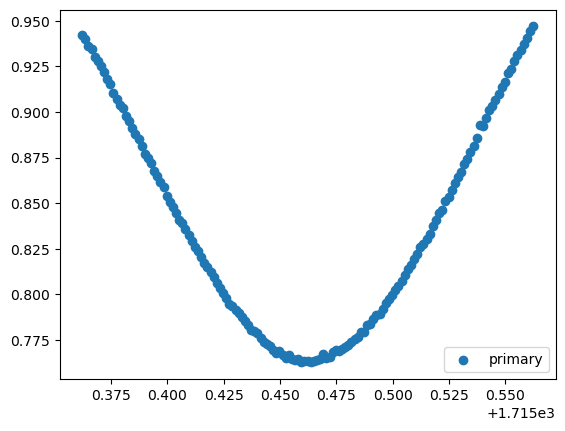

1699.2054 16.256853 1731.719106


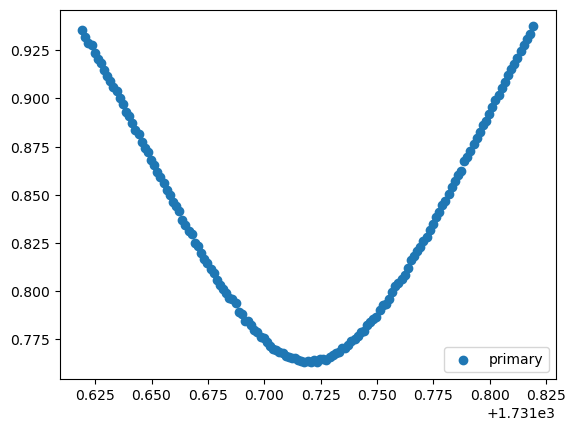

1691.7634 16.256853 1691.7634


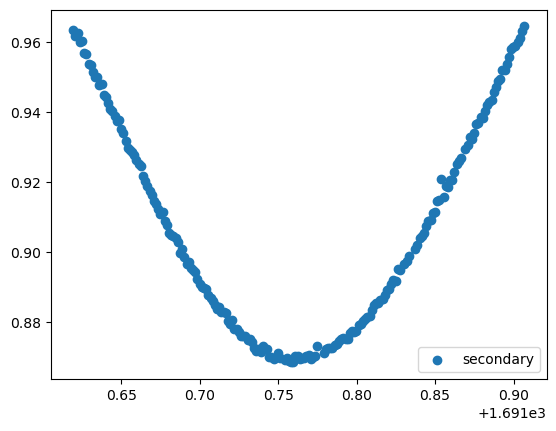

1691.7634 16.256853 1708.0202530000001


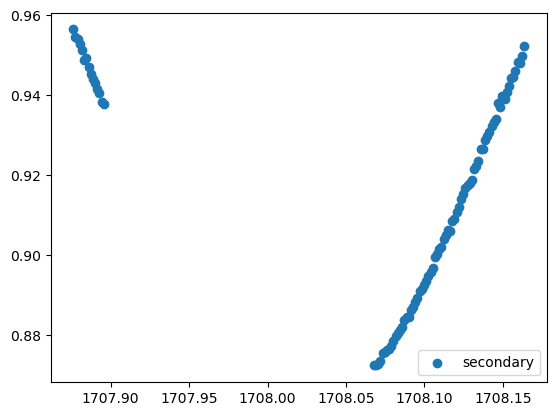

1691.7634 16.256853 1724.277106


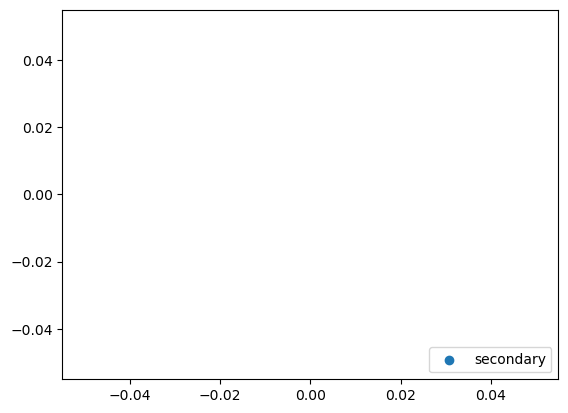

In [20]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

for i in tr_index[0:3]:        
    transit_time = t0_secondary+(period*i)
    x = np.array(data_secondary.time)
    y = np.array(data_secondary.flux) 
    yerr = np.array(data_secondary.err)
    
    print (t0_secondary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="secondary")
    plt.legend(loc="lower right")
    plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1715.4622530000001 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.51it/s]


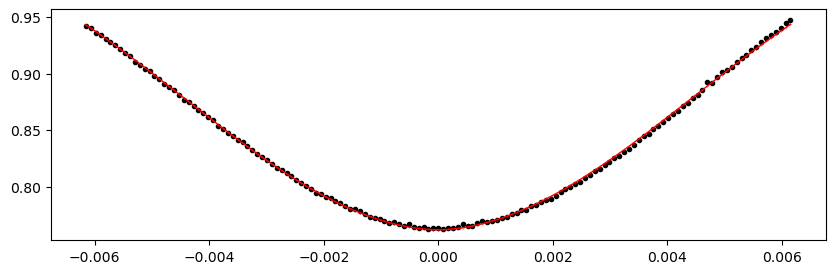

1731.719106 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.11it/s]


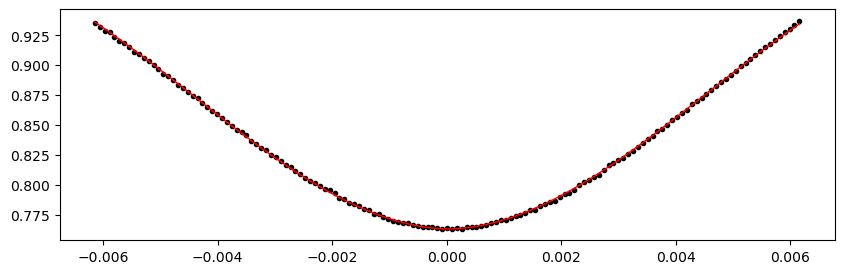

1747.975959 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.74it/s]


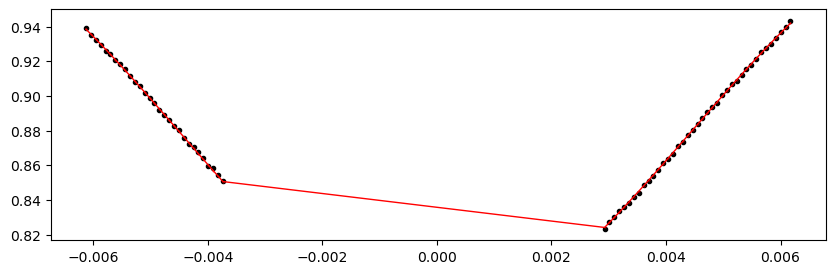

1845.517077 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.03it/s]


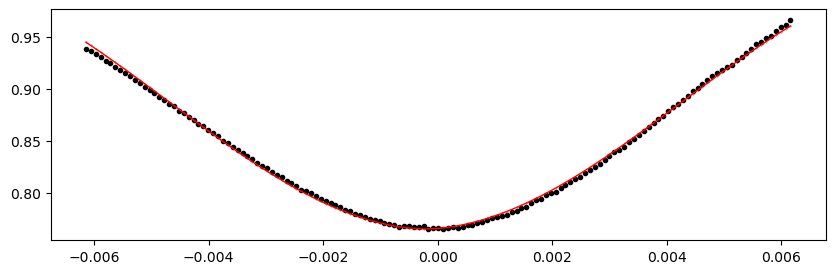

1861.77393 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.45it/s]


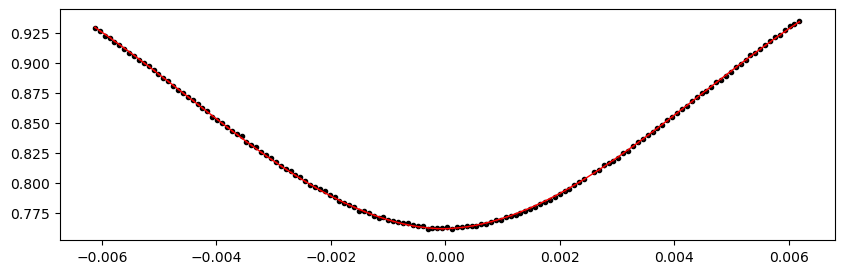

1878.0307830000002 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.66it/s]


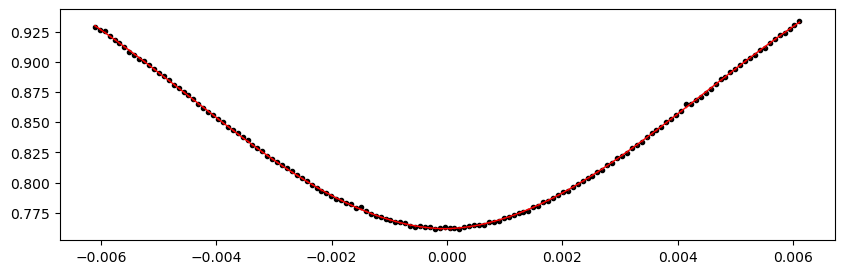

1894.287636 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.40it/s]


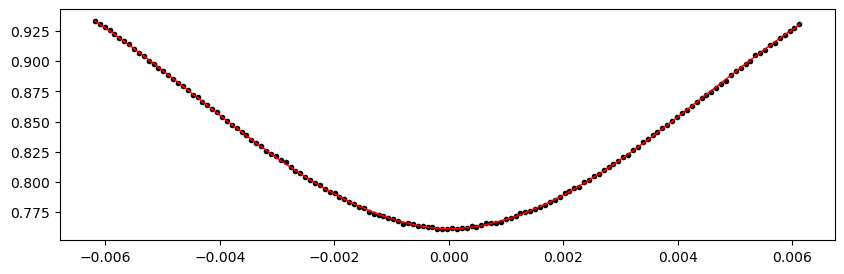

1910.544489 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.83it/s]


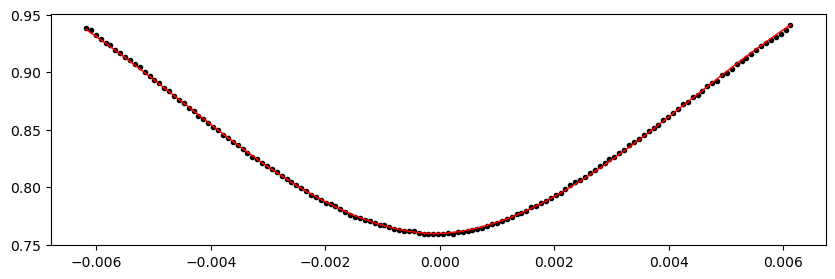

2024.34246 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.88it/s]


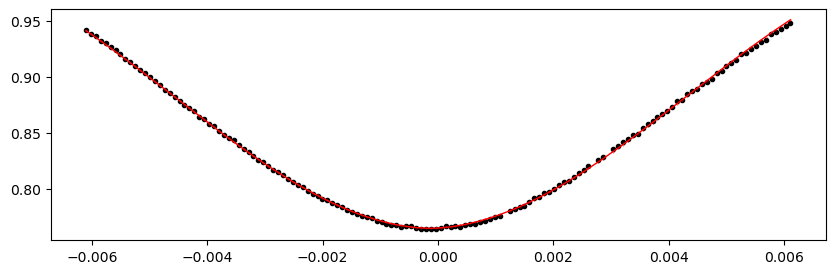

2398.250079 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.07it/s]


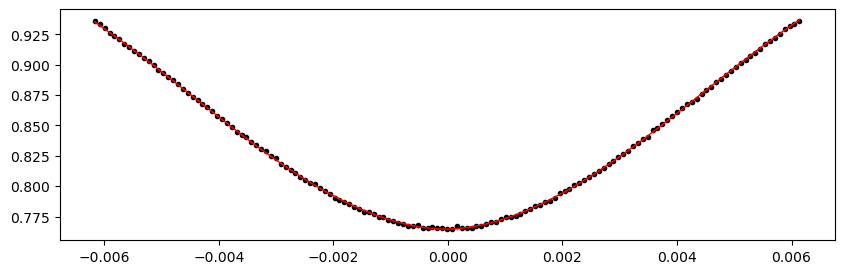

2414.5069320000002 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.92it/s]


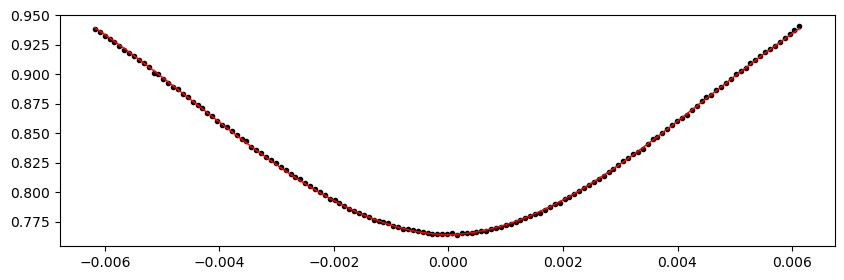

2430.763785 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.17it/s]


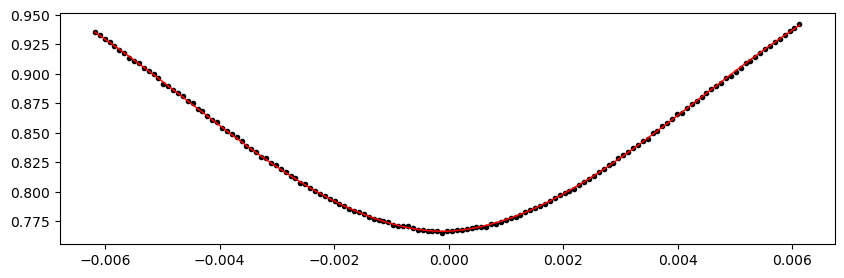

2625.8460210000003 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.58it/s]


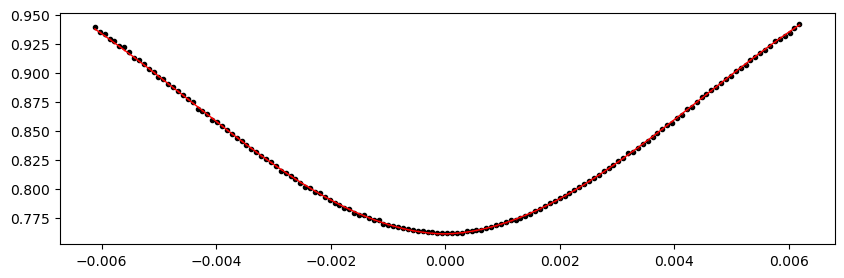

2642.102874 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.35it/s]


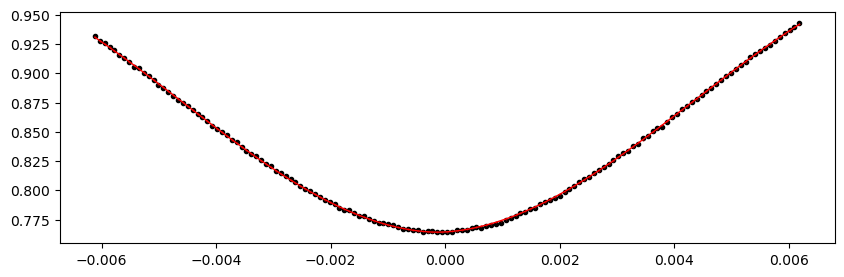

2658.359727 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.65it/s]


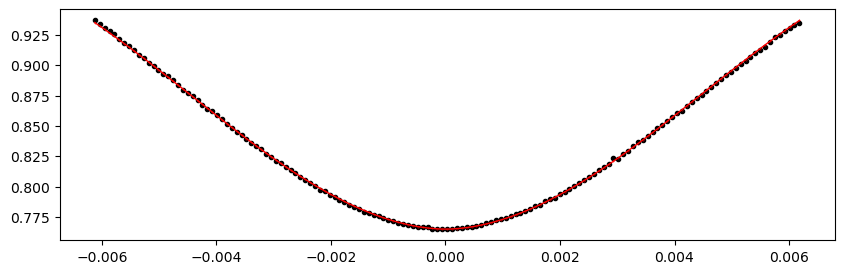

2674.61658 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.09it/s]


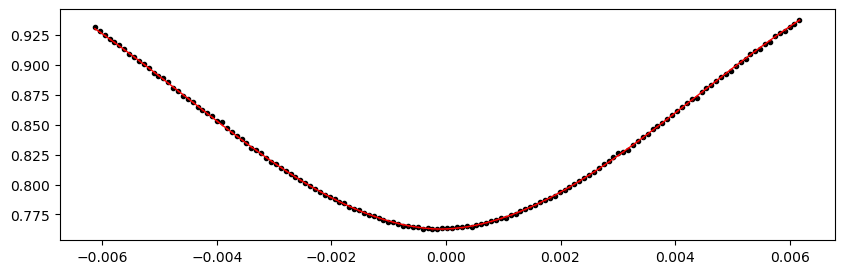

2690.8734329999997 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.31it/s]


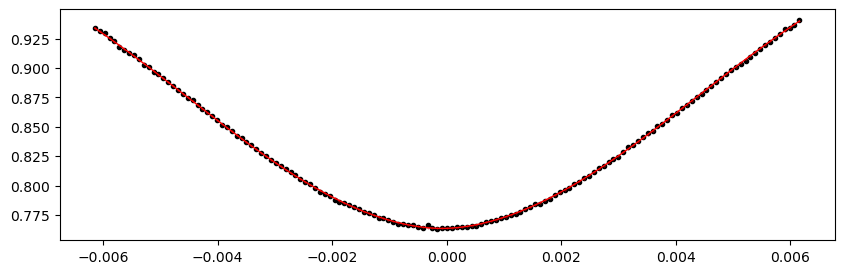

2755.900845 1.0131438511860815 -0.2502983827192327 0.3378100490671454


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.32it/s]


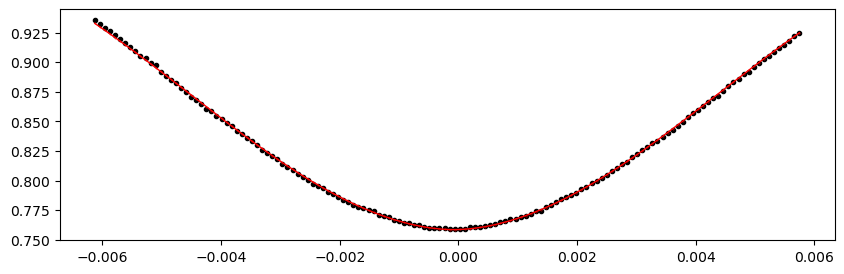

In [24]:
print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path)

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1708.0202530000001 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.82it/s]


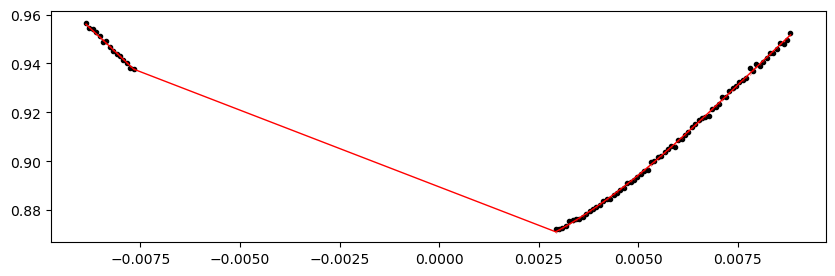

1740.533959 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.57it/s]


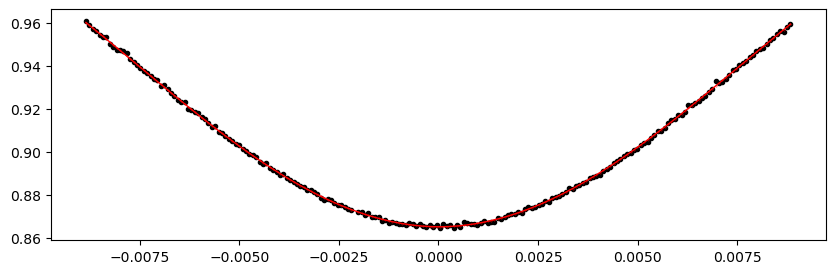

1756.790812 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.77it/s]


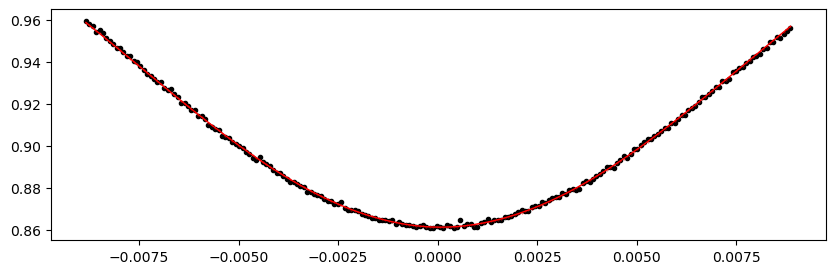

1854.33193 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.98it/s]


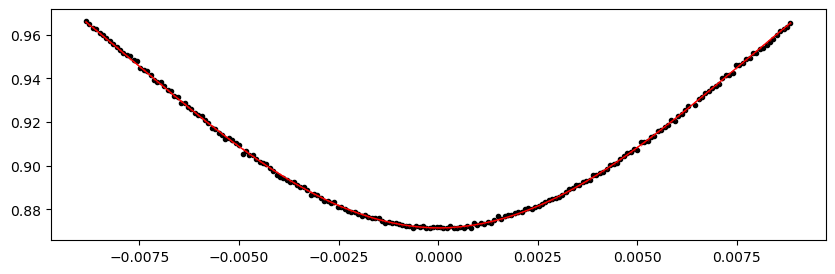

1870.5887830000001 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.11it/s]


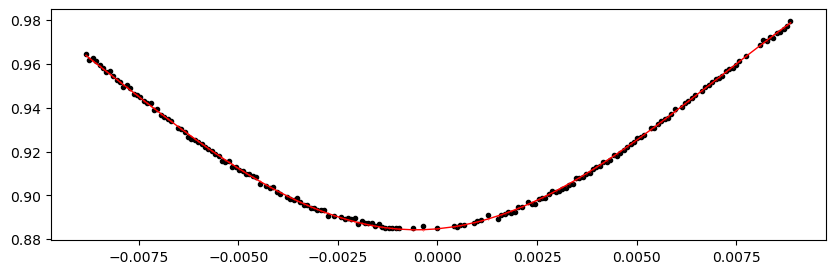

1886.845636 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.84it/s]


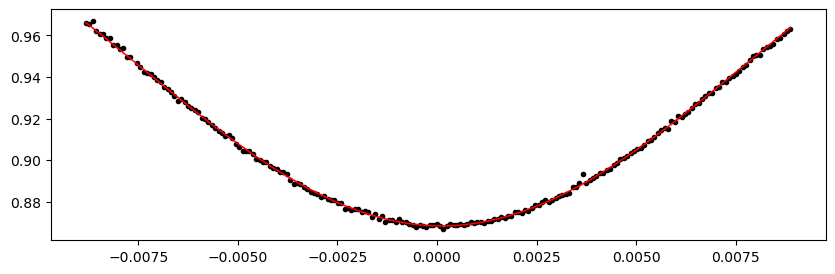

1903.102489 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.46it/s]


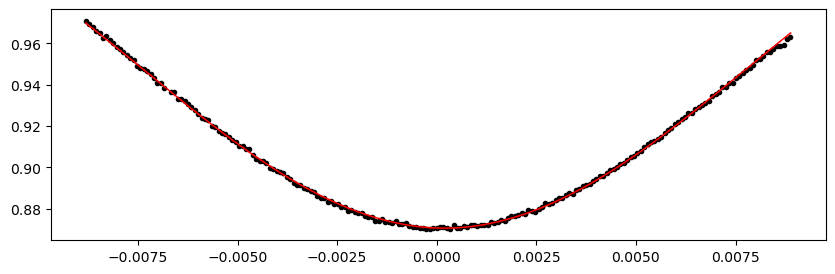

1919.359342 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.72it/s]


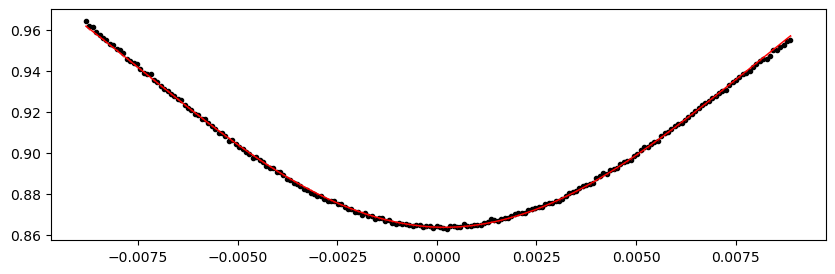

1935.616195 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.56it/s]


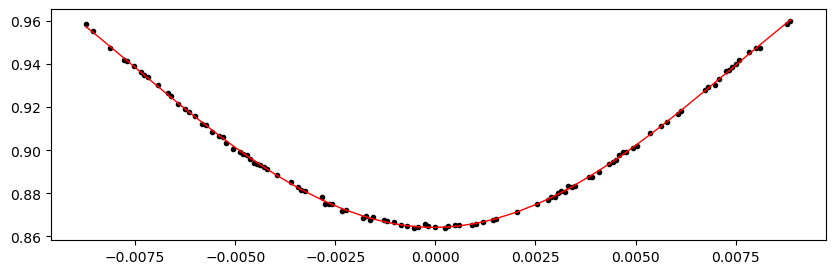

1951.873048 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.06it/s]


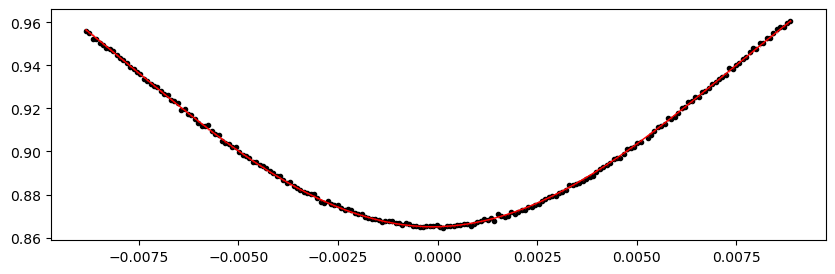

2016.90046 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.82it/s]


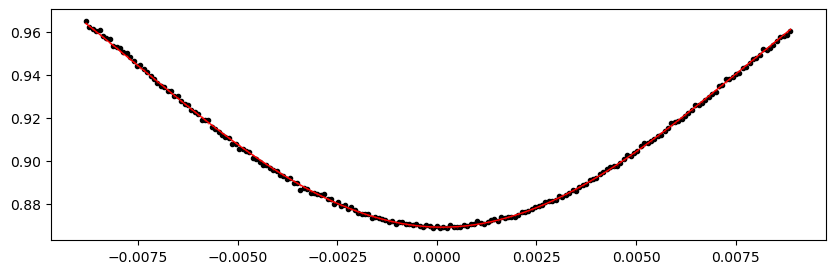

2033.1573130000002 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.04it/s]


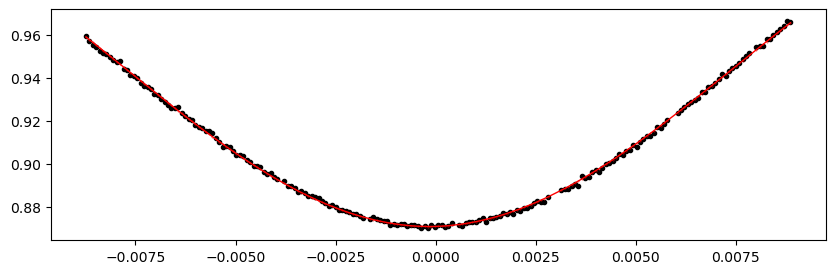

2390.808079 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.00it/s]


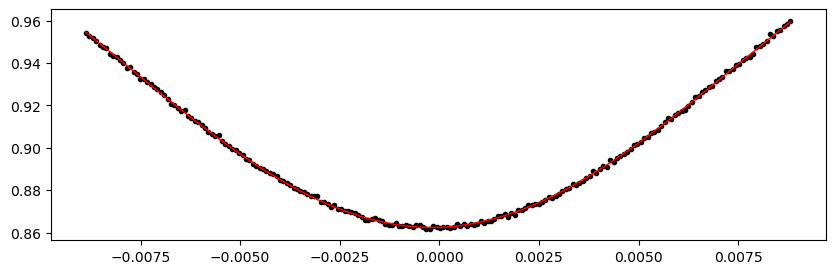

2407.064932 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.87it/s]


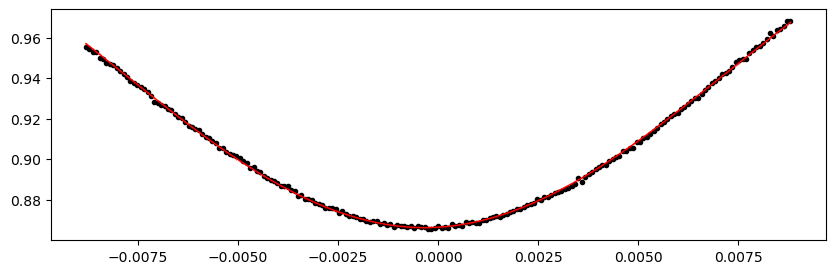

2423.321785 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.93it/s]


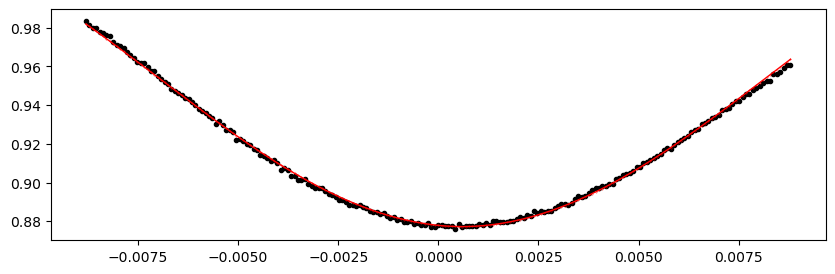

2439.578638 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.38it/s]


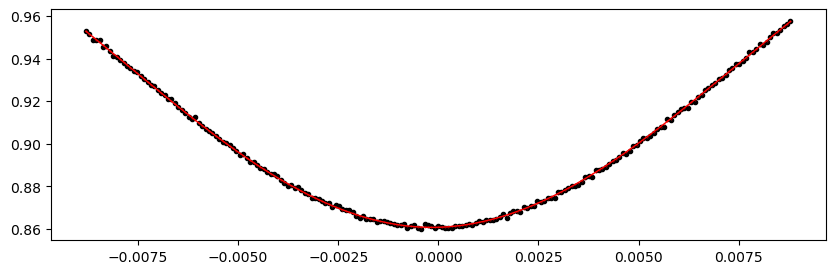

2585.890315 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.25it/s]


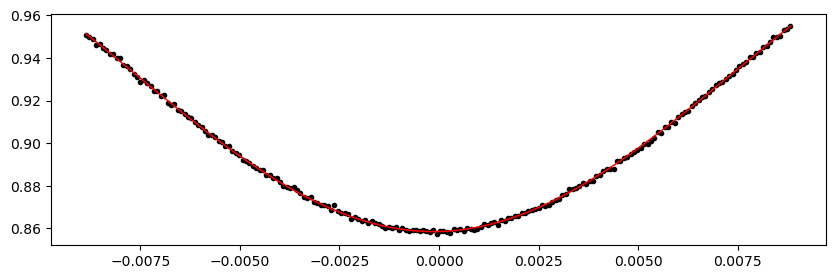

2602.147168 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.22it/s]


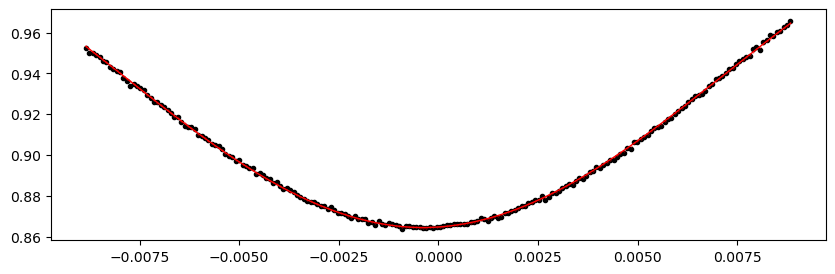

2618.4040210000003 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.02it/s]


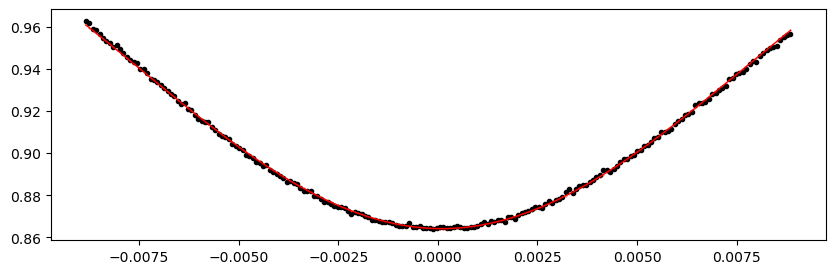

2634.660874 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.12it/s]


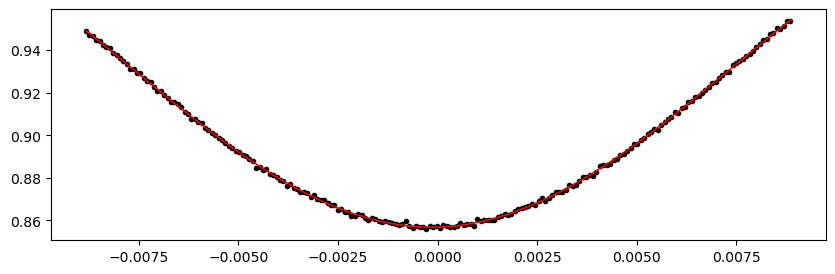

2683.4314329999997 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.38it/s]


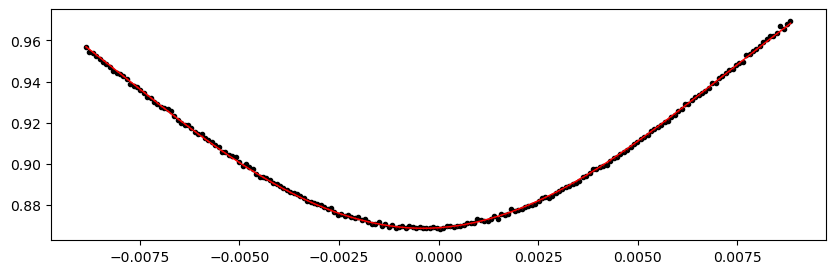

2748.458845 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.92it/s]


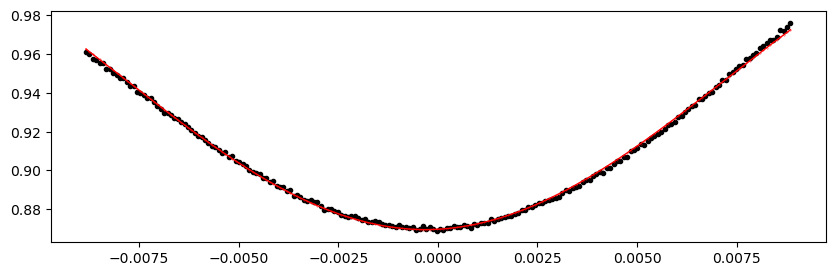

2764.715698 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.97it/s]


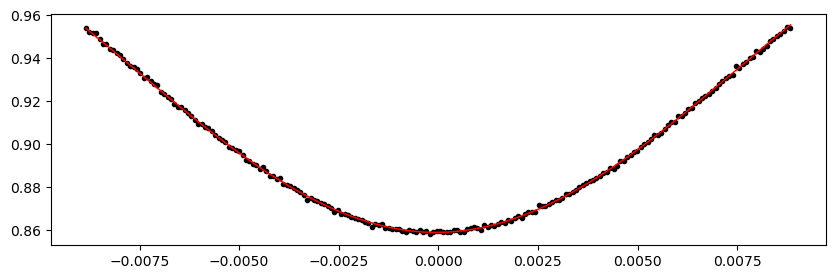

2829.7431100000003 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.82it/s]


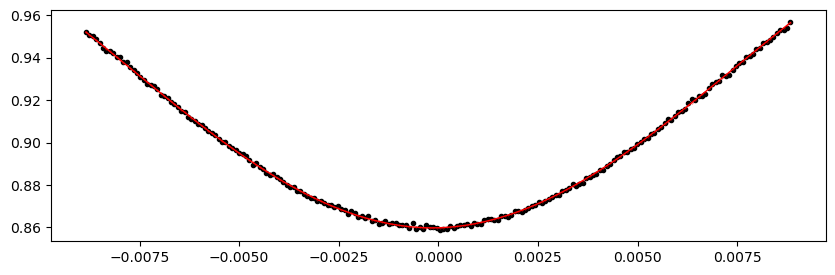

2845.999963 1.0296357359316894 -0.16348427376787952 -0.12004152621387412


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.24it/s]


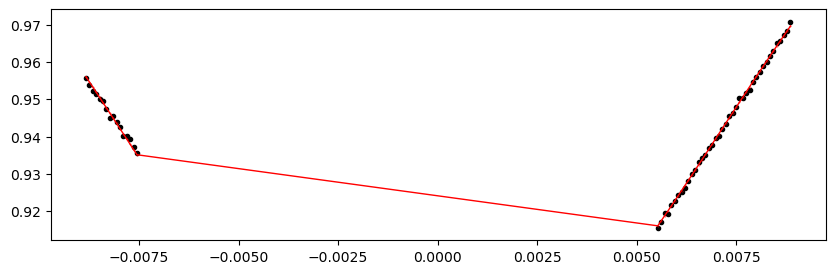

In [25]:
print("Fitting individual secondary eclipses...")
etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s)

!$NOTIFY_CMD "Fitting individual eclipses done"

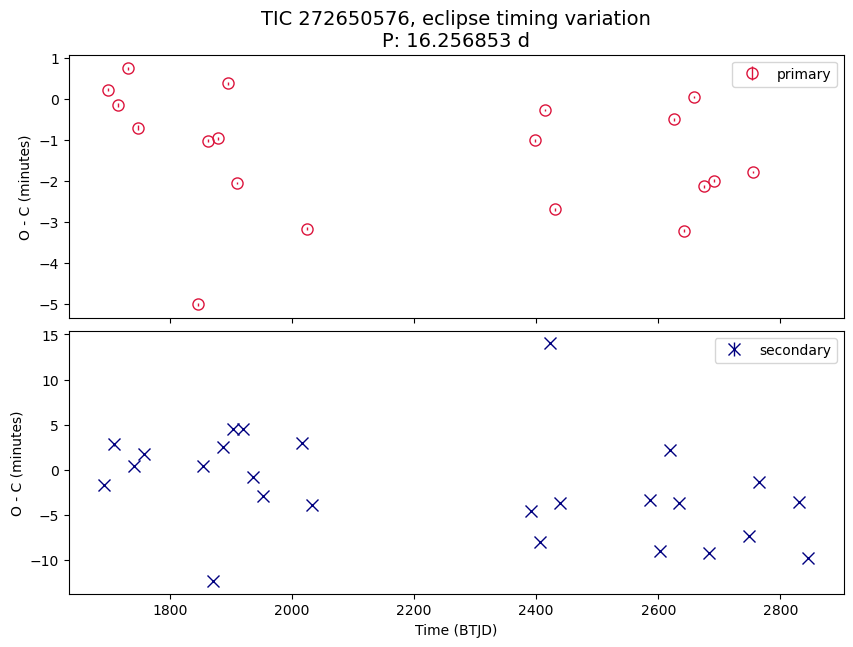

In [26]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

in_df_primary = pd.read_csv(outfile_path)
in_df_secondary = pd.read_csv(outfile_path_s)


in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60

axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
             lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### Compare with O-C plot with ingres/egress included

with ingress/egress included

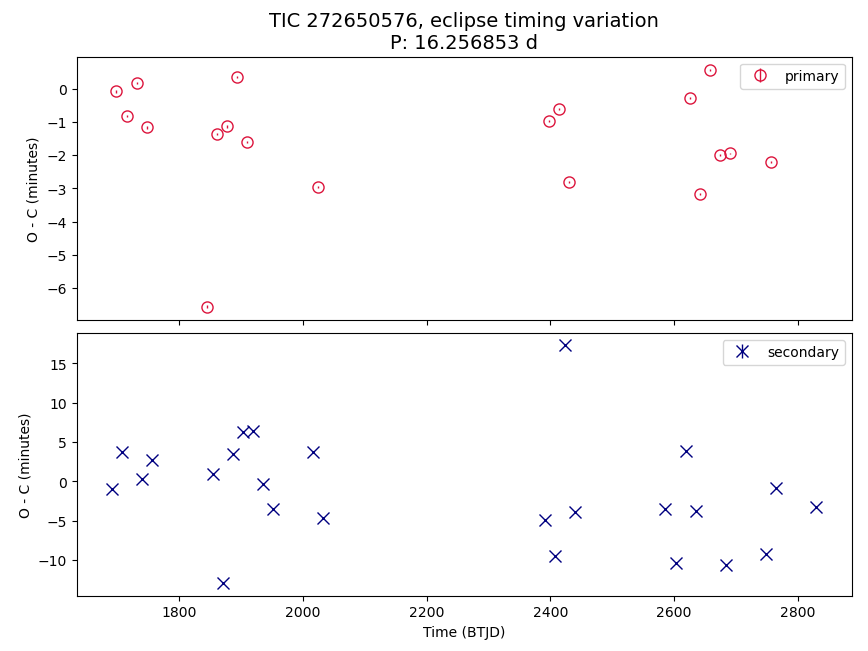

### Compare with the result from TCE1 Period and old `log_prior_fitting()`

Old `log_prior_fitting()` returns `-np.inf` when `not (-0.16 < alpha1 < 0)`, i.e., depth > 16%

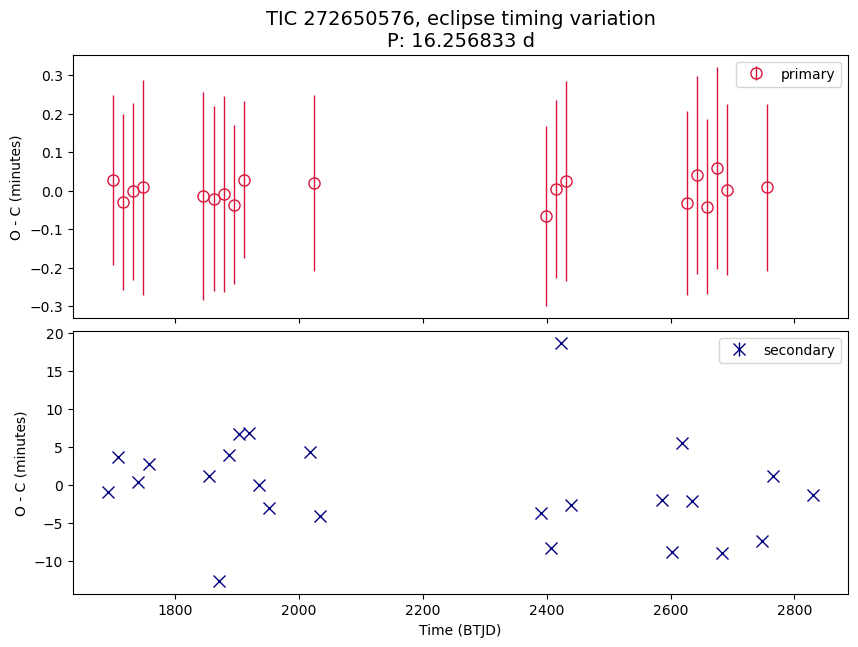

## make a periodogram 

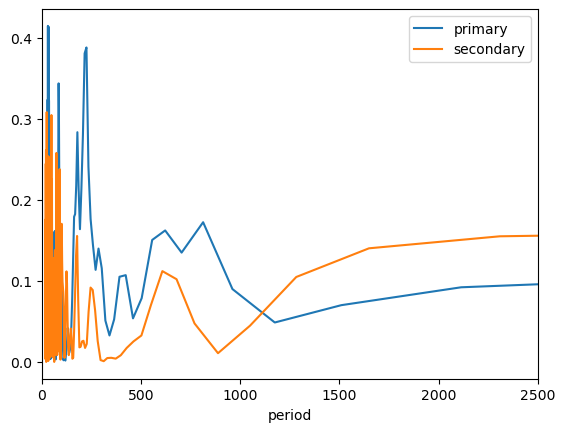

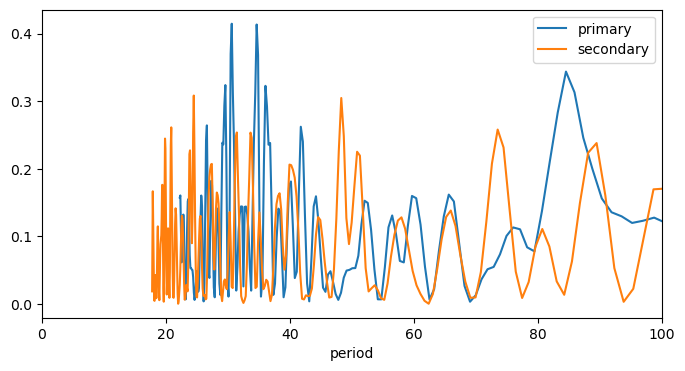

In [28]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()
frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    
plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2500)
plt.show()

if True:  # zoom-in
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

In [30]:
# FILL-IN the ETV results / comments
has_etv = "?"
comments = "Scatter in O-C for both primary and secondary, with amplitude of ~6 min and <20 min. Data possibly too sparse. OPEN: considerable short-term variation possibly make ETV unreliable. [D*0.7]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

,0
tic,272650576
has_etv,?
comments,"Scatter in O-C for both primary and secondary, with amplitude of ~6 min and <20 min. Data possibly too sparse. OPEN: considerable short-term variation possibly make ETV unreliable. [D*0.7]"
period,16.256853
depth_pct_p,25.03
depth_pct_s,16.35
epoch_p,1699.2054
epoch_s,1691.7634
num_sectors,18
time_span,1684.13



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
272650576,?,"Scatter in O-C for both primary and secondary, with amplitude of ~6 min and <20 min. Data possibly too sparse. OPEN: considerable short-term variation possibly make ETV unreliable. [D*0.7]",16.256853,25.03,16.35,1699.2054,1691.7634,18,1684.13,1683.35,3367.48

